In [129]:
# Import Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Data file downloaded 02-27-18
# This will be the file used, data is from 11/1/15 to 2/20/18

# Assign filename
data_022718 = 'crime-datacrime-datacrimestat.csv'

# Read file in DataFrame
crime = pd.read_csv(data_022718, sep=',', low_memory=False, dtype={'ZIP': object})

# Quick view of the data
print(crime.head())
print(crime.info())

# Rename columns
crime.columns = ['incident_num', 'date_occurred_on', 'date_occurred_to', 'crime_cat', '100_block_addr', 'zip', 'premise_type']


        INC NUMBER        OCCURRED ON        OCCURRED TO   UCR CRIME CATEGORY  \
0  201600000052855  11/01/2015  00:00  01/09/2016  00:00  MOTOR VEHICLE THEFT   
1  201600000594484  11/01/2015  00:00                NaN                 RAPE   
2  201500002102327  11/01/2015  00:00  11/01/2015  09:00        LARCENY-THEFT   
3  201500002101405  11/01/2015  00:00  11/01/2015  05:00  MOTOR VEHICLE THEFT   
4  201500002102668  11/01/2015  00:00  11/01/2015  11:50  MOTOR VEHICLE THEFT   

             100 BLOCK ADDR    ZIP         PREMISE TYPE  
0  N 43RD AVE & W CACTUS RD  85029  SINGLE FAMILY HOUSE  
1         13XX E ALMERIA RD  85006  SINGLE FAMILY HOUSE  
2            51XX N 15TH ST  85014            APARTMENT  
3       102XX W MEDLOCK AVE  85307  SINGLE FAMILY HOUSE  
4            69XX W WOOD ST  85043  SINGLE FAMILY HOUSE  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148468 entries, 0 to 148467
Data columns (total 7 columns):
INC NUMBER            148468 non-null object
OCCURRED O

In [130]:
# 4 variables have missing data: Occurred On, Occurred To, Zip, Premise Type
print(crime[['date_occurred_on', 'date_occurred_to', 'zip', 'premise_type']].isna().sum())
# 'date_occurred_to' field is blank because the victim knows the exact time the incident occurred and only the 'date_occurred_on' is populated

# Sum number of incidents where occurred_on and occurred_to are NaN
print(crime[(crime.date_occurred_on.isna()) & (crime.date_occurred_to.isna())])

# 
print(crime.loc[crime['zip'].isna()])
print(crime.loc[crime['date_occurred_on'].isna()].head())
print(crime.loc[crime['date_occurred_to'].isna()].head())
print(crime.loc[crime['premise_type'].isna()].head())

date_occurred_on      336
date_occurred_to    43719
zip                     3
premise_type          805
dtype: int64
Empty DataFrame
Columns: [incident_num, date_occurred_on, date_occurred_to, crime_cat, 100_block_addr, zip, premise_type]
Index: []
          incident_num   date_occurred_on   date_occurred_to      crime_cat  \
63037  201700001136425  11/04/2016  00:00  06/25/2017  00:00           RAPE   
79708  201700000206086  02/04/2017  10:00  02/04/2017  10:14  LARCENY-THEFT   
82276  201700000368400  02/18/2017  12:00  02/27/2017  15:23  LARCENY-THEFT   

             100_block_addr  zip             premise_type  
63037       451XX W RHEA RD  NaN                APARTMENT  
79708     XX W BASELINE AVE  NaN          SPECIALTY STORE  
82276  122XX N TABLE TOP RD  NaN  FENCED RESIDENTIAL YARD  
         incident_num date_occurred_on   date_occurred_to      crime_cat  \
248   201500002110561              NaN  11/02/2015  14:40        ROBBERY   
275   201500002132194              NaN  11

In [131]:
# Identify the unique values
print(crime[['crime_cat', 'zip', 'premise_type']].nunique())
print(crime.crime_cat.unique())
print(crime.zip.unique())
#print(crime.premise_type.unique())

crime_cat        9
zip             99
premise_type    94
dtype: int64
['MOTOR VEHICLE THEFT' 'RAPE' 'LARCENY-THEFT' 'DRUG OFFENSE' 'BURGLARY'
 'AGGRAVATED ASSAULT' 'MURDER AND NON-NEGLIGENT MANSLAUGHTER' 'ROBBERY'
 'ARSON']
['85029' '85006' '85014' '85307' '85043' '85017' '85085' '85019' '85031'
 '85027' '85024' '85339' '85028' '85018' '85015' '85008' '85254' '85051'
 '85023' '85009' '85044' '85035' '85041' '85003' '85048' '85353' '85016'
 '85022' '85033' '85040' '85007' '85050' '85004' '85054' '85032' '85013'
 '85034' '85042' '85021' '85012' '85053' '85308' '85086' '85020' '85037'
 '85331' '85306' '85083' '85310' '85045' '85087' '85301' '85253' '85304'
 '85255' '85251' '85258' '85225' '85363' '85282' '85268' '85213' '85395'
 '85202' '85201' '85381' '85281' '85210' '85323' '85224' '85345' '85302'
 '85266' '85382' '85392' '85303' '85260' '85286' '85296' '85203' '85248'
 '85295' '85290' '85326' '85234' '85283' '85215' '85226' '85257' '85305'
 nan '85383' '85204' '85337' '85396' '85338' '

In [132]:
# Cleaning the data set

# Remove missing zip code rows and convert to str
crime_clean = crime.drop(crime.index[[63037, 79708, 82276]])
print(crime_clean.loc[crime_clean['zip'].isna()])

# Fill in missing date values with date_occurred_on or date_occurred_to
crime_clean.date_occurred_on.fillna(crime_clean.date_occurred_to, inplace=True)
print(crime_clean.iloc[248])
crime_clean.date_occurred_to.fillna(crime_clean.date_occurred_on, inplace=True)
print(crime_clean.iloc[24])
print(crime_clean[['date_occurred_on', 'date_occurred_to']].isna().sum())

# Premise type NaN convert to Unknown
crime_clean.premise_type = crime_clean.premise_type.fillna('UNKNOWN')


Empty DataFrame
Columns: [incident_num, date_occurred_on, date_occurred_to, crime_cat, 100_block_addr, zip, premise_type]
Index: []
incident_num                            201500002110561
date_occurred_on                      11/02/2015  14:40
date_occurred_to                      11/02/2015  14:40
crime_cat                                       ROBBERY
100_block_addr                       41XX W BASELINE RD
zip                                               85041
premise_type        STREET / ROADWAY / ALLEY / SIDEWALK
Name: 248, dtype: object
incident_num                   201500002100158
date_occurred_on             11/01/2015  00:05
date_occurred_to             11/01/2015  00:05
crime_cat                  MOTOR VEHICLE THEFT
100_block_addr             28XX W CAMELBACK RD
zip                                      85017
premise_type        CONVENIENCE MARKET / STORE
Name: 24, dtype: object
date_occurred_on    0
date_occurred_to    0
dtype: int64


In [133]:
# Convert date columns to datetime
crime_clean['date_occurred_on'] = pd.to_datetime(crime_clean['date_occurred_on'], format='%m/%d/%Y %H:%M')
crime_clean['date_occurred_to'] = pd.to_datetime(crime_clean['date_occurred_to'], format='%m/%d/%Y %H:%M')
#crime_clean.info()

# Break down datetime columns into seperate columns, new columns listed below
# date_occ_on ==> [occ_on_month, occ_on_day, occ_on_year, occ_on_hr, occ_on_min]
crime_clean['occ_on_month'] = crime_clean['date_occurred_on'].dt.month
crime_clean['occ_on_day'] = crime_clean['date_occurred_on'].dt.day
crime_clean['occ_on_year'] = crime_clean['date_occurred_on'].dt.year
crime_clean['occ_on_dayofweek'] = crime_clean['date_occurred_on'].dt.weekday_name
crime_clean['occ_on_time'] = crime_clean['date_occurred_on'].dt.time
crime_clean['occ_on_hr'] = crime_clean['date_occurred_on'].dt.hour
crime_clean['occ_on_min'] = crime_clean['date_occurred_on'].dt.minute

# date_occ_to ==> [occ_to_month, occ_to_day, occ_to_year, occ_to_hr, occ_to_min]
crime_clean['occ_to_month'] = crime_clean['date_occurred_to'].dt.month
crime_clean['occ_to_day'] = crime_clean['date_occurred_to'].dt.day
crime_clean['occ_to_year'] = crime_clean['date_occurred_to'].dt.year
crime_clean['occ_to_dayofweek'] = crime_clean['date_occurred_to'].dt.weekday_name
crime_clean['occ_to_time'] = crime_clean['date_occurred_to'].dt.time
crime_clean['occ_to_hr'] = crime_clean['date_occurred_to'].dt.hour
crime_clean['occ_to_min'] = crime_clean['date_occurred_to'].dt.minute

crime_clean.head()
crime_clean.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 148465 entries, 0 to 148467
Data columns (total 21 columns):
incident_num        148465 non-null object
date_occurred_on    148465 non-null datetime64[ns]
date_occurred_to    148465 non-null datetime64[ns]
crime_cat           148465 non-null object
100_block_addr      148465 non-null object
zip                 148465 non-null object
premise_type        148465 non-null object
occ_on_month        148465 non-null int64
occ_on_day          148465 non-null int64
occ_on_year         148465 non-null int64
occ_on_dayofweek    148465 non-null object
occ_on_time         148465 non-null object
occ_on_hr           148465 non-null int64
occ_on_min          148465 non-null int64
occ_to_month        148465 non-null int64
occ_to_day          148465 non-null int64
occ_to_year         148465 non-null int64
occ_to_dayofweek    148465 non-null object
occ_to_time         148465 non-null object
occ_to_hr           148465 non-null int64
occ_to_min          14

In [134]:
# Classify incident times into 4hr bucket groups
# A: 0-3, B: 4-7, C: 8-11, D: 12-15, E: 16-19, F: 20-23
occ_on_hr_grp = []
for row in crime_clean.occ_on_hr:
    if row in [0,1,2,3]:
        occ_on_hr_grp.append('A')
    elif row in [4,5,6,7]:
        occ_on_hr_grp.append('B')
    elif row in [8,9,10,11]:
        occ_on_hr_grp.append('C')
    elif row in [12,13,14,15]:
        occ_on_hr_grp.append('D')
    elif row in [16,17,18,19]:
        occ_on_hr_grp.append('E')
    else: 
        occ_on_hr_grp.append('F')
    
crime_clean['occ_on_hr_grp'] = occ_on_hr_grp


In [135]:
# Classify incident months into seasons
# Spring(3,4,5), Summer(6,7,8), Fall(9,10,11), Winter(12,1,2)
occ_on_season = []
for row in crime_clean.occ_on_month:
    if row in [3,4,5]:
        occ_on_season.append('Spring')
    elif row in [6,7,8]:
        occ_on_season.append('Summer')
    elif row in [9,10,11]:
        occ_on_season.append('Fall')
    else:
        occ_on_season.append('Winter')
        
crime_clean['occ_on_season'] = occ_on_season

# crime_clean is the clean data set

# Exploratory Data Analysis

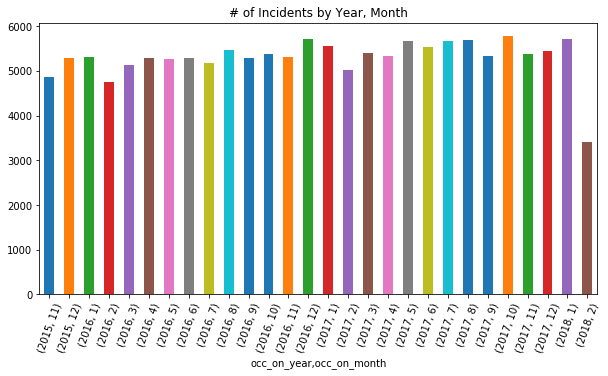

In [136]:
# Number of incidents per month by year
inc_mon_yr = crime_clean.groupby(['occ_on_year', 'occ_on_month'])['incident_num'].count()
inc_mon_yr
inc_mon_yr.plot(kind='bar', figsize=(10,5), rot=70)
plt.title('# of Incidents by Year, Month')
plt.show()

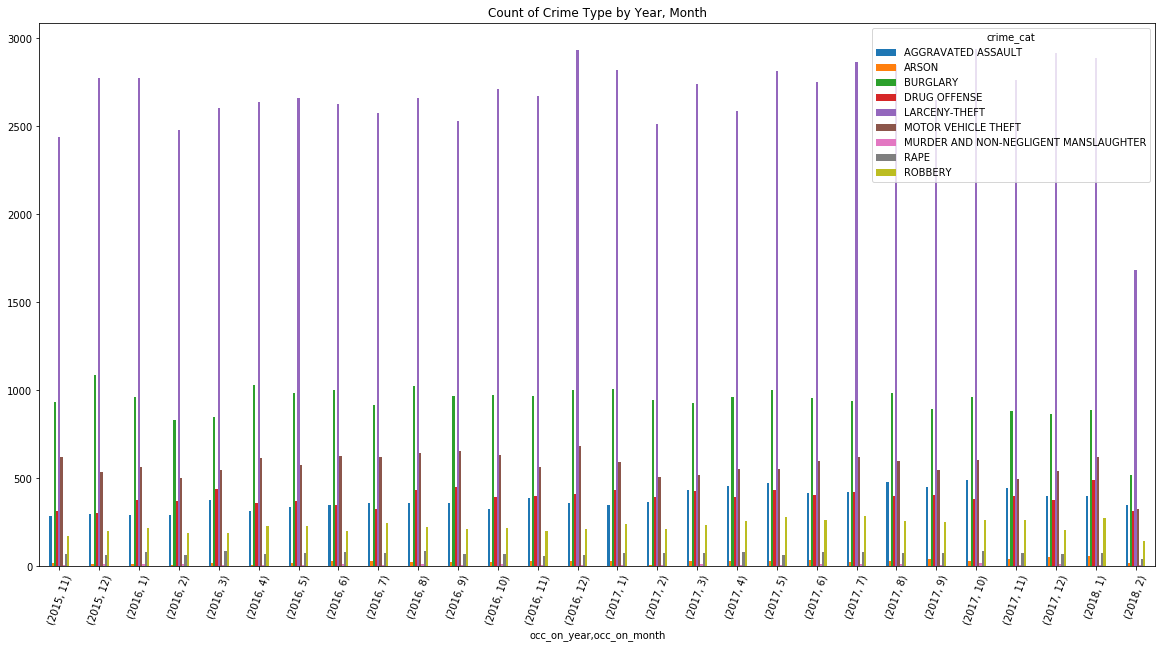

In [137]:
# Number of types of crime per month by year
crime_month = crime_clean.groupby(['occ_on_year','occ_on_month','crime_cat'])['crime_cat'].count()
crime_month.unstack().plot(kind='bar', figsize=(20,10), rot=70)
plt.title('Count of Crime Type by Year, Month')
plt.show()

occ_on_dayofweek
Friday       22600
Wednesday    21864
Tuesday      21774
Thursday     21615
Monday       21217
Saturday     20468
Sunday       18927
Name: incident_num, dtype: int64


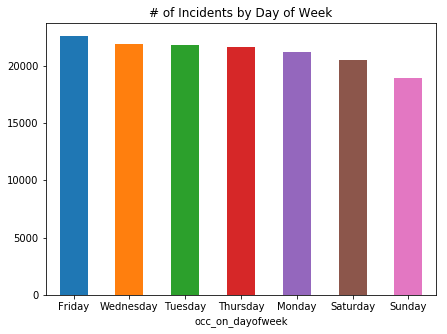

In [138]:
# Day of the week crimes take place
crime_dayofweek = crime_clean.groupby('occ_on_dayofweek')['incident_num'].count().sort_values(ascending=False)
print(crime_dayofweek)
crime_dayofweek.plot(kind='bar', figsize=(7,5), rot=0)
plt.title('# of Incidents by Day of Week')
plt.show()

occ_on_hr_grp
E    33717
D    29432
F    29193
C    22367
A    20489
B    13267
Name: incident_num, dtype: int64


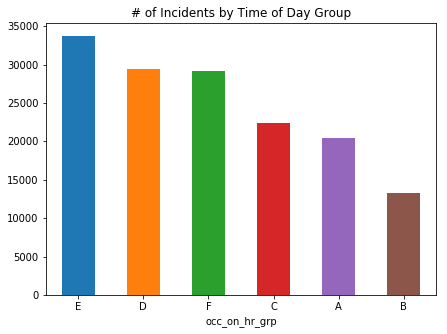

In [139]:
# Time of Day crimes occur
# A: 0-3, B: 4-7, C: 8-11, D: 12-15, E: 16-19, F: 20-23
crime_timeofday = crime_clean.groupby('occ_on_hr_grp')['incident_num'].count().sort_values(ascending=False)
print(crime_timeofday[:10])
crime_timeofday.plot(kind='bar', figsize=(7,5), rot=0,)
plt.title('# of Incidents by Time of Day Group')
plt.show()

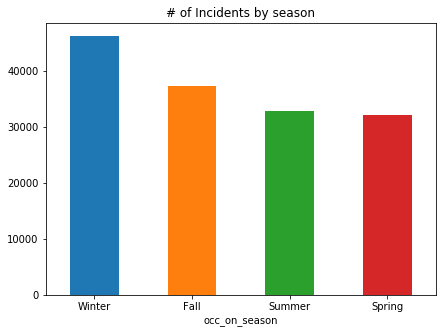

In [140]:
# Time of year most crimes occurred
season_inc = crime_clean.groupby('occ_on_season')['occ_on_season'].count().sort_values(ascending=False)
season_inc
season_inc.plot(kind='bar', figsize=(7,5), rot=0)
plt.title('# of Incidents by season')
plt.show()

In [141]:
# Market Basket Analysis

# Import mlxtend packages
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules

crime_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148465 entries, 0 to 148467
Data columns (total 23 columns):
incident_num        148465 non-null object
date_occurred_on    148465 non-null datetime64[ns]
date_occurred_to    148465 non-null datetime64[ns]
crime_cat           148465 non-null object
100_block_addr      148465 non-null object
zip                 148465 non-null object
premise_type        148465 non-null object
occ_on_month        148465 non-null int64
occ_on_day          148465 non-null int64
occ_on_year         148465 non-null int64
occ_on_dayofweek    148465 non-null object
occ_on_time         148465 non-null object
occ_on_hr           148465 non-null int64
occ_on_min          148465 non-null int64
occ_to_month        148465 non-null int64
occ_to_day          148465 non-null int64
occ_to_year         148465 non-null int64
occ_to_dayofweek    148465 non-null object
occ_to_time         148465 non-null object
occ_to_hr           148465 non-null int64
occ_to_min          14

In [142]:
# Create basket list
basket = crime_clean[['crime_cat', 'zip', 'premise_type', '100_block_addr', 'occ_on_month', 'occ_on_day', 'occ_on_year', 'occ_on_hr_grp', 'occ_on_dayofweek', 'occ_on_season']].values.tolist()


In [143]:
# one-hot encode the data and frequent items
te = TransactionEncoder()
te_ary = te.fit(basket).transform(basket)
basket_encode = pd.DataFrame(te_ary, columns=te.columns_)
basket_encode.head()

TypeError: '<' not supported between instances of 'int' and 'str'

In [122]:
frequent_itemsets = apriori(basket_encode, min_support=0.025, use_colnames=True)
frequent_itemsets

KeyboardInterrupt: 

In [109]:
# Confidence Metric
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.025)
rules

,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


In [16]:
# Lift Metric
rules_1 = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)
rules_1

,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(APARTMENT),(BURGLARY),0.113246,0.177059,0.029408,0.259680,1.466633,0.009357,1.111602
1,(BURGLARY),(APARTMENT),0.177059,0.113246,0.029408,0.166090,1.466633,0.009357,1.063369
2,(SINGLE FAMILY HOUSE),(BURGLARY),0.188671,0.177059,0.092864,0.492199,2.779868,0.059458,1.620600
3,(BURGLARY),(SINGLE FAMILY HOUSE),0.177059,0.188671,0.092864,0.524480,2.779868,0.059458,1.706193
4,(LARCENY-THEFT),(DEPARTMENT / DISCOUNT STORE),0.504382,0.029785,0.027023,0.053577,1.798801,0.012000,1.025139
5,(DEPARTMENT / DISCOUNT STORE),(LARCENY-THEFT),0.029785,0.504382,0.027023,0.907282,1.798801,0.012000,5.345427
6,(LARCENY-THEFT),(DRIVEWAY),0.504382,0.035039,0.026525,0.052589,1.500881,0.008852,1.018524
7,(DRIVEWAY),(LARCENY-THEFT),0.035039,0.504382,0.026525,0.757017,1.500881,0.008852,2.039721
8,(GROCERY / SUPER MARKET),(LARCENY-THEFT),0.027508,0.504382,0.025050,0.910627,1.805433,0.011175,5.545496
9,(LARCENY-THEFT),(GROCERY / SUPER MARKET),0.504382,0.027508,0.025050,0.049664,1.805433,0.011175,1.023314
